Magnitude,[[[0.0913686 0.0909875 0.0910225 ... 0.0941083 0.0940129 0.0944882] [0.1856806 0.186377 0.1836514 ... 0.1856486 0.1850836 0.1842172]] [[0.227516 0.2297024 0.2261366 ... 0.2264519 0.2271665 0.226713] [0.6354927 0.637668 0.6298023 ... 0.6072068 0.6087293 0.6091066]] [[0.1064704 0.1066212 0.1053444 ... 0.121114 0.1205022 0.1205441] [0.2755033 0.2761615 0.2727006 ... 0.2911952 0.2900544 0.2909847]] ... [[0.2027881 0.1996586 0.2004866 ... 0.2318743 0.2311941 0.2330808] [0.4666358 0.4554404 0.4561614 ... 0.4809749 0.4812827 0.4862896]] [[0.4885007 0.4802285 0.4818338 ... 0.6109142 0.6108118 0.613845] [0.8457658 0.825988 0.8259648 ... 0.975894 0.9756599 0.9826459]] [[0.6304559 0.6284427 0.6287045 ... 0.6810626 0.6809573 0.6818709] [1.2285622 1.2205907 1.2190002 ... 1.2729124 1.2727222 1.2755645]]]
Units,volt


<xarray.DataArray 'time' (time: 23239)> Size: 186kB
array([0.000000e+00, 1.280000e-01, 2.560000e-01, ..., 2.974208e+03,
       2.974336e+03, 2.974464e+03])
Coordinates:
  * time     (time) float64 186kB 0.0 0.128 0.256 ... 2.974e+03 2.974e+03
    samples  (time) int32 93kB 0 1 2 3 4 5 ... 23234 23235 23236 23237 23238
Attributes:
    units:    second

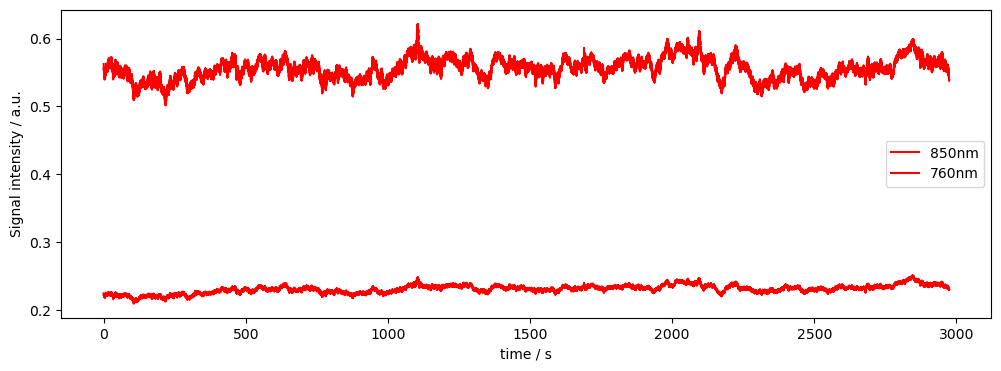

In [1]:
import cedalion
import cedalion.nirs
import cedalion.sigproc.quality as quality
import cedalion.sigproc.motion_correct as motion_correct
import cedalion.xrutils as xrutils
import cedalion.datasets as datasets
import xarray as xr
import matplotlib.pyplot as p
import cedalion.plots as plots
from cedalion import units
import numpy as np

import cedalion.sim.synthetic_hrf as shrf

rec = datasets.get_fingertapping()
rec["od"] = cedalion.nirs.int2od(rec["amp"])


f,ax = p.subplots(1,1, figsize=(12,4))
ax.plot( rec["amp"].time, rec["amp"].sel(channel="S3D3", wavelength="850"), "r-", label="850nm")
ax.plot( rec["amp"].time, rec["amp"].sel(channel="S3D3", wavelength="760"), "r-", label="760nm")
p.legend()
ax.set_xlabel("time / s")
ax.set_ylabel("Signal intensity / a.u.")

display(rec["amp"])
display(rec["amp"].time)



,onset,duration,trial_type,value,channel
0,500,5,spike,1,[S3D3]
1,750,5,spike,1,[S3D3]
2,1500,5,spike,1,[S3D3]
3,2000,1,bl_shift,1,None


Adding spike at 500 for 5 to ['S3D3']
Adding spike at 750 for 5 to ['S3D3']
Adding spike at 1500 for 5 to ['S3D3']
Adding bl_shift at 2000 for 1 to all channels


Text(0, 0.5, 'Signal intensity / a.u.')

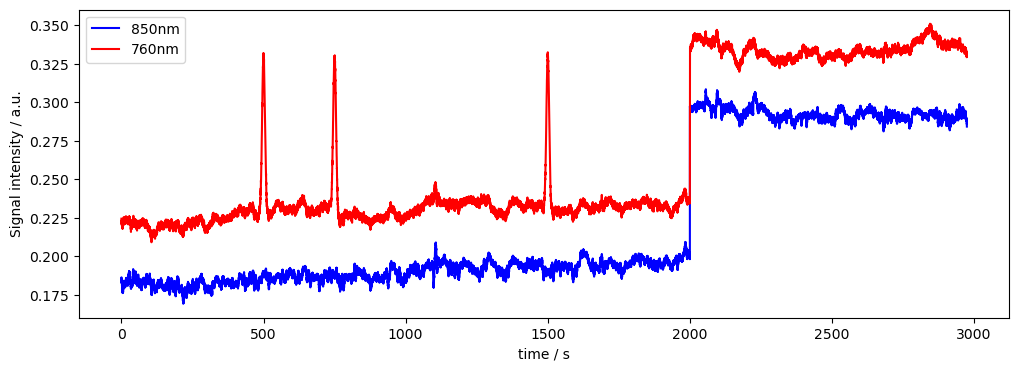

In [2]:
import cedalion.sim.synthetic_artifact as sa
spikes = [(500, 5), (750, 5), (1500, 5)]
timing = sa.add_event_timing(spikes, 'spike', ['S3D3'])
bl_shift = [(2000, 1)]
timing = sa.add_event_timing(bl_shift, 'bl_shift', None, timing)
display(timing)
rec["amp_art3"] = sa.add_artifacts_amp(rec["amp"], timing, 1)

f,ax = p.subplots(1,1, figsize=(12,4))
ax.plot( rec["amp_art3"].time, rec["amp_art3"].sel(channel="S1D1", wavelength="850"), "b-", label="850nm")
ax.plot( rec["amp_art3"].time, rec["amp_art3"].sel(channel="S3D3", wavelength="760"), "r-", label="760nm")
p.legend()
ax.set_xlabel("time / s")
ax.set_ylabel("Signal intensity / a.u.")

Adding spike at 1933.992598968843 for 14.95019245559934 to all channels
Adding spike at 166.60680031737544 for 648.8974902689747 to all channels
Adding bl_shift at 2142.0304542886083 for 83.74485236524531 to all channels


Text(0, 0.5, 'Signal intensity / a.u.')

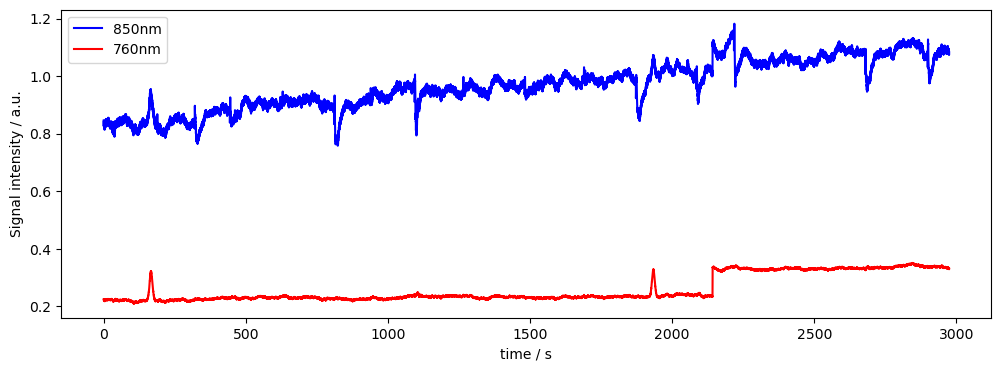

In [3]:
rand_arts = sa.gen_random_events(rec["amp"].time, 3, ['spike', 'bl_shift'])
rec["amp_art_rand"] = sa.add_artifacts_amp(rec["amp"], rand_arts)

f,ax = p.subplots(1,1, figsize=(12,4))
ax.plot( rec["amp_art_rand"].time, rec["amp_art_rand"].sel(channel="S8D8", wavelength="850"), "b-", label="850nm")
ax.plot( rec["amp_art_rand"].time, rec["amp_art_rand"].sel(channel="S3D3", wavelength="760"), "r-", label="760nm")
p.legend()
ax.set_xlabel("time / s")
ax.set_ylabel("Signal intensity / a.u.")